# Imports

In [86]:

# coding: utf-8

# # Imports

# ## Qutip imports 1

# In[1]:


from qutip.operators import sigmax, sigmay, sigmaz, identity
# position, momentum, num, create, destroy, commutator, qeye 
from qutip.tensor import tensor
from qutip.qip.gates import swap, rx, ry, rz
from qutip.qobj import Qobj
from qutip.visualization import hinton
from qutip.visualization import matrix_histogram_complex, matrix_histogram
from qutip.random_objects import rand_herm, rand_unitary, rand_dm


# ## Qutip imports 2

# In[2]:


#from 


# ## Numpy imports 

# In[2]:


from numpy import sin, cos, tan, real, imag,  log, conj
from numpy import array, append, linspace, arange
from numpy import add, sqrt, abs, dot
from numpy.random import random, random_sample, rand, seed, RandomState
from numpy import concatenate, trace, diag
from numpy import ones, zeros, ones_like, zeros_like
from numpy import amax, amin, nanmax, nanmin
from numpy import outer, multiply
# from numpy import pi


# ## Scipy imports

# In[17]:


from scipy.integrate import ode, odeint, complex_ode
from scipy.optimize import minimize
from scipy.linalg import eigh, inv, norm, expm
# from scipy.linalg import 
# from scipy import


# ## Matplotlib imports

# In[18]:


from matplotlib.pyplot import plot, figure, show, savefig, axes
from matplotlib.pyplot import xlabel, ylabel, title, legend
from matplotlib import rcParams
from matplotlib.pyplot import style 
from matplotlib.pyplot import xlim, ylim, axis 
# beware not same as axes
from matplotlib.pyplot import subplot, subplots, text
from matplotlib.pyplot import GridSpec
from matplotlib.pyplot import scatter, colorbar


pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
rcParams.update(pgf_with_rc_fonts)
style.use('seaborn-whitegrid')


# ## Math imports

# In[19]:


from math import pi
from math import exp


# ## Cmath imports

# ## Date and datetime imports

# In[20]:


from datetime import date
from datetime import datetime# now


# ## Os imports

# In[21]:


from os import getcwd, mkdir, chdir
from os.path import abspath, join 


# ## Sympy imports

# In[22]:


from sympy import Function, dsolve, Eq, Derivative, symbols
# x, y, z, t = symbols('x y z t')
# k, m, n = symbols('k m n', integer=True)
# f, g, h = symbols('f g h', cls=Function)


# ## Miscellaneous imports

# ## Extra useful functions

# In[23]:


def rint(x):
    print("x = ", x)
    return None


# # Next chapter

# ## sub topic 1

# ## sub topic 2

# ## sub topic 3

# ### sub sub topic 1



# The code

## memory wiping

In [87]:
%reset_selective -f  omega_1, total_time, epsilon, max_iter, time_steps, dt

In [88]:
%reset_selective -f  Lin, T_s, I

## Building parts

### Building the things to be calculated only once

In [89]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [90]:
omega_1 = 0.5
H_0 = sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [91]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [92]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [93]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [94]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [95]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [96]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [97]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [98]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [99]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [100]:
fidelity_calc(sigmax(), sigmay())

4.0

In [101]:
fidelity_calc(sigmay(), sigmay())

0.0

In [102]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [103]:
xi_vec_test.size

2

In [104]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [105]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487144

In [106]:
L_v = L_vec(xi_vec_test, 0.001)

In [107]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [108]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [109]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [110]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [111]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [113]:
def terminator(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial =  1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

# Running stuff

### Try1

In [114]:
total_time = pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [115]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([253.12809151+0.j, 843.88141913+0.j, 670.69241692+0.j,
       924.100077  +0.j, 342.69688787+0.j, 123.45758492+0.j,
       879.26165155+0.j, 520.4459173 +0.j, 339.72130347+0.j,
       984.45194508+0.j,  64.74984188+0.j,  81.10046078+0.j,
         2.82873766+0.j, 265.22266621+0.j, 207.7809171 +0.j,
       834.24591251+0.j, 964.13437576+0.j, 875.54876982+0.j,
       129.61146026+0.j, 466.77550287+0.j])

In [117]:
F(xi_opt, dt)

-3.9789212334927573

In [118]:
max_iter

10

In [120]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [122]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.28233594+0.j         -0.16005333-0.00893544j -0.16005333+0.00893544j
   0.71766406+0.j        ]
 [ 0.14342862-0.05006893j -0.05447685+0.00321831j -0.30317032+0.17678044j
  -0.14342862+0.05006893j]
 [ 0.14342862+0.05006893j -0.30317032-0.17678044j -0.05447685-0.00321831j
  -0.14342862-0.05006893j]
 [ 0.71766406+0.j          0.16005333+0.00893544j  0.16005333-0.00893544j
   0.28233594+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b792400>)

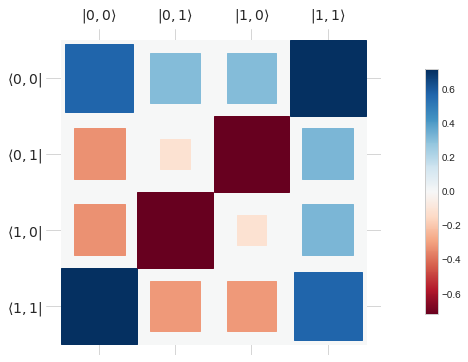

In [123]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [124]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [125]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([689.08841007+0.j, 390.64027158+0.j, 911.13324832+0.j,
       649.25993828+0.j,  21.5494225 +0.j, 950.60143484+0.j,
       699.39692259+0.j, 548.59433605+0.j, 803.89473054+0.j,
       597.13507604+0.j, 309.1677551 +0.j, 971.84119957+0.j,
       769.04692813+0.j, 118.73798072+0.j, 983.40518658+0.j,
       905.52213367+0.j, 496.59607212+0.j, 303.01896702+0.j,
       670.38160789+0.j, 202.11102251+0.j])

In [126]:
F(xi_opt, dt)

-3.0928457729772094

In [127]:
max_iter

10

In [128]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [129]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.45551215+0.j         -0.06146264-0.00195095j -0.06146264+0.00195095j
   0.54448785+0.j        ]
 [ 0.06117515+0.00113601j -0.03304158+0.00393467j -0.05606434-0.00328859j
  -0.06117515-0.00113601j]
 [ 0.06117515-0.00113601j -0.05606434+0.00328859j -0.03304158-0.00393467j
  -0.06117515+0.00113601j]
 [ 0.54448785+0.j          0.06146264+0.00195095j  0.06146264-0.00195095j
   0.45551215+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b8bbfd0>)

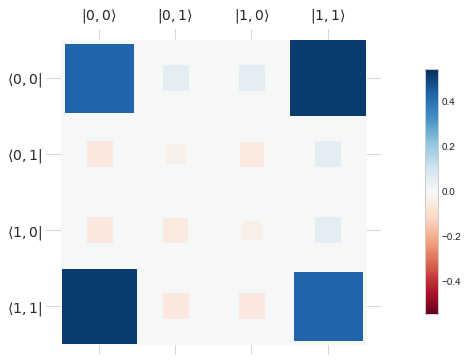

In [130]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [131]:
total_time = 4*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [132]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([ 16.89916348+0.j, 546.14147796+0.j, 370.939413  +0.j,
       661.52831589+0.j, 798.83010196+0.j, 856.15192907+0.j,
       425.39661272+0.j, 817.52733909+0.j, 542.12425634+0.j,
       229.37722665+0.j, 478.03467099+0.j, 376.19661666+0.j,
        86.82178311+0.j, 103.98801384+0.j, 196.90523493+0.j,
       363.43670343+0.j, 985.59180376+0.j, 402.12328368+0.j,
        84.7572926 +0.j, 232.78104093+0.j])

In [133]:
F(xi_opt, dt)

-3.0267105841205595

In [134]:
max_iter

10

In [135]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [136]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.50075015+0.j         -0.04042479+0.00209092j -0.04042479-0.00209092j
   0.49924985+0.j        ]
 [ 0.04040024-0.0001695j   0.00395634+0.00194311j -0.00264077-0.00210981j
  -0.04040024+0.0001695j ]
 [ 0.04040024+0.0001695j  -0.00264077+0.00210981j  0.00395634-0.00194311j
  -0.04040024-0.0001695j ]
 [ 0.49924985+0.j          0.04042479-0.00209092j  0.04042479+0.00209092j
   0.50075015+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1c72b550>)

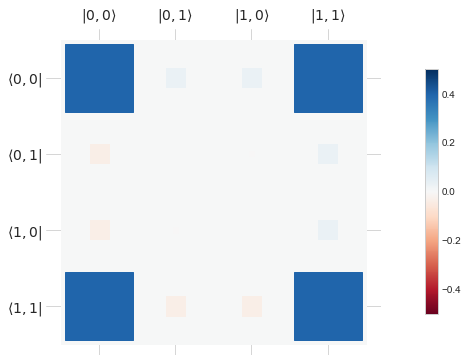

In [137]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [138]:
total_time = 5*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [139]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([628.17131461+0.j, 621.00810422+0.j, 439.92123557+0.j,
       156.38281485+0.j, 465.46461684+0.j, 270.63279773+0.j,
        99.52810023+0.j, 719.96038964+0.j, 654.20655632+0.j,
       357.27197278+0.j, 552.479709  +0.j, 118.15844016+0.j,
       766.75569369+0.j,  54.27830497+0.j, 606.98591267+0.j,
        55.8853009 +0.j, 789.00040693+0.j, 261.21559934+0.j,
       431.40575825+0.j,  34.05616042+0.j])

In [140]:
F(xi_opt, dt)

-3.0073840748657643

In [141]:
max_iter

10

In [142]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [143]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.48143832+0.00000000e+00j -0.01104882-6.04904832e-05j
  -0.01104882+6.04904832e-05j  0.51856168+0.00000000e+00j]
 [ 0.01106675+3.22991450e-04j -0.01760639+7.27686769e-05j
  -0.0194739 +8.10880513e-05j -0.01106675-3.22991450e-04j]
 [ 0.01106675-3.22991450e-04j -0.0194739 -8.10880513e-05j
  -0.01760639-7.27686769e-05j -0.01106675+3.22991450e-04j]
 [ 0.51856168+0.00000000e+00j  0.01104882+6.04904832e-05j
   0.01104882-6.04904832e-05j  0.48143832+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1c89a2e8>)

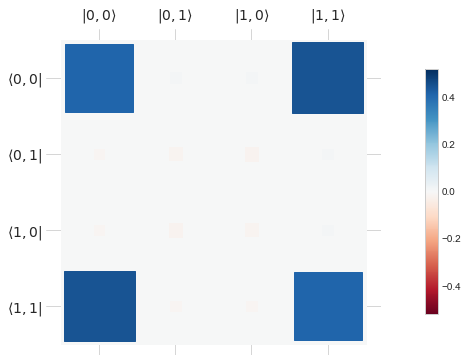

In [144]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [145]:
total_time = 10*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [146]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([220.65427093+0.j, 970.69580696+0.j, 196.02473416+0.j,
       518.3824284 +0.j, 196.17410136+0.j, 569.29816989+0.j,
       525.43050372+0.j, 582.48769888+0.j, 825.28818866+0.j,
       573.19779378+0.j, 167.06560055+0.j, 706.39522048+0.j,
       799.88874054+0.j, 233.38500557+0.j, 857.47048837+0.j,
       301.22153915+0.j, 430.17789507+0.j, 529.32407831+0.j,
       477.18004331+0.j, 505.03960374+0.j])

In [147]:
F(xi_opt, dt)

-3.000012804373343

In [148]:
max_iter

10

In [149]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [150]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00331048e-01+0.00000000e+00j  8.72894594e-04-4.07373240e-07j
   8.72894594e-04+4.07373239e-07j  4.99668952e-01+0.00000000e+00j]
 [-8.72964131e-04-1.43928154e-07j  3.33074701e-04-6.04114892e-06j
   3.29589841e-04+4.12707186e-06j  8.72964131e-04+1.43928154e-07j]
 [-8.72964131e-04+1.43928154e-07j  3.29589841e-04-4.12707186e-06j
   3.33074701e-04+6.04114892e-06j  8.72964131e-04-1.43928154e-07j]
 [ 4.99668952e-01+0.00000000e+00j -8.72894594e-04+4.07373239e-07j
  -8.72894594e-04-4.07373239e-07j  5.00331048e-01+0.00000000e+00j]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cb249e8>)

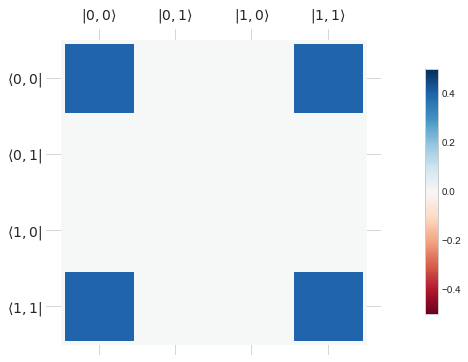

In [151]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [152]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 200
dt = total_time/time_steps

In [153]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([288.06686264+0.j, 622.29612295+0.j, 814.80791134+0.j,
       354.13137538+0.j, 556.40653629+0.j, 448.91127838+0.j,
       382.64161479+0.j,  38.5904663 +0.j, 928.27857183+0.j,
       662.66718274+0.j, 638.02530971+0.j, 751.97562161+0.j,
       967.0555933 +0.j, 380.26114369+0.j, 141.45725626+0.j,
       768.66710373+0.j, 478.15325684+0.j, 363.79048785+0.j,
       583.33543587+0.j, 957.31294485+0.j, 635.84371521+0.j,
       247.72466574+0.j, 918.76206305+0.j, 340.80456   +0.j,
       187.54258364+0.j, 866.47122121+0.j, 266.57521808+0.j,
       863.37046314+0.j, 205.9434985 +0.j, 612.70097585+0.j,
       614.35842895+0.j, 894.65886781+0.j, 790.89660687+0.j,
       777.28738052+0.j, 761.44157438+0.j, 838.2818755 +0.j,
       888.08215549+0.j, 220.3199309 +0.j, 590.96027899+0.j,
        17.24425449+0.j, 790.74982354+0.j, 770.98877452+0.j,
       460.41517739+0.j, 599.98783936+0.j, 109.59332672+0.j,
       906.95112751+0.j, 181.56060215+0.j, 241.32652595+0.j,
       232.35277044+0.j,

In [154]:
F(xi_opt, dt)

-3.0867364617339534

In [155]:
max_iter

10

In [156]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [157]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.56939082+0.j          0.01697523-0.01269891j  0.01697523+0.01269891j
   0.43060918+0.j        ]
 [-0.02393377-0.00423045j  0.07783901-0.02465407j  0.05867054-0.01040459j
   0.02393377+0.00423045j]
 [-0.02393377+0.00423045j  0.05867054+0.01040459j  0.07783901+0.02465407j
   0.02393377-0.00423045j]
 [ 0.43060918+0.j         -0.01697523+0.01269891j -0.01697523-0.01269891j
   0.56939082+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cc97d30>)

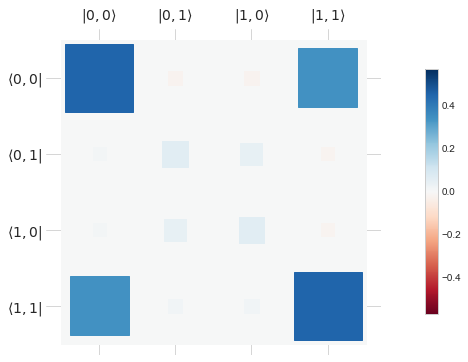

In [158]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [159]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 50
dt = total_time/time_steps

In [160]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([353.3100824 +0.j, 473.35015665+0.j, 359.14595728+0.j,
       193.9300171 +0.j, 827.03698377+0.j, 690.1913909 +0.j,
       203.43927386+0.j, 505.45389548+0.j, 795.08411285+0.j,
       403.65880929+0.j, 950.63613659+0.j, 998.74492503+0.j,
       531.23141942+0.j, 875.32093197+0.j, 485.80377805+0.j,
       275.26950681+0.j, 944.63680802+0.j, 244.23753631+0.j,
       276.44933701+0.j, 742.95655165+0.j, 686.64125621+0.j,
       974.0032684 +0.j, 351.2920594 +0.j, 373.40633633+0.j,
       429.49870718+0.j,  23.71428865+0.j, 136.94367489+0.j,
       464.84552026+0.j, 828.86561709+0.j, 753.99998213+0.j,
       833.5249114 +0.j, 362.33738467+0.j, 293.93189866+0.j,
       615.66125089+0.j, 855.06458143+0.j, 561.16911479+0.j,
       212.6261282 +0.j, 234.74015125+0.j, 604.99639923+0.j,
       731.97892777+0.j, 646.73903181+0.j, 444.52499083+0.j,
       882.43316819+0.j, 506.31198339+0.j, 387.16631709+0.j,
       956.75365769+0.j, 476.7332489 +0.j, 642.06285296+0.j,
       214.4125193 +0.j,

In [161]:
F(xi_opt, dt)

-3.093487139195682

In [162]:
max_iter

10

In [163]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [164]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.53142341+0.j         -0.06904032-0.0001394j  -0.06904032+0.0001394j
   0.46857659+0.j        ]
 [ 0.06921856-0.00089447j  0.04276297-0.00030057j  0.01970634+0.00052942j
  -0.06921856+0.00089447j]
 [ 0.06921856+0.00089447j  0.01970634-0.00052942j  0.04276297+0.00030057j
  -0.06921856-0.00089447j]
 [ 0.46857659+0.j          0.06904032+0.0001394j   0.06904032-0.0001394j
   0.53142341+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cceb748>)

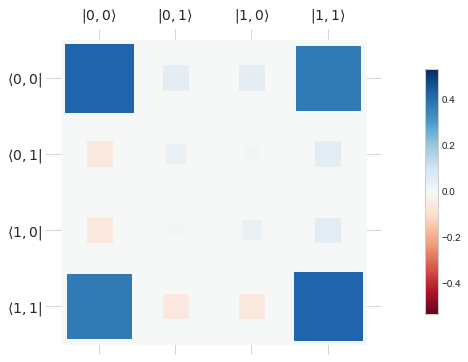

In [165]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [166]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 20#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [167]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([342.52193884+0.j, 576.77794742+0.j, 355.13470186+0.j,
       793.75389646+0.j, 564.62396905+0.j, 885.87738677+0.j,
        30.3802794 +0.j, 992.11061091+0.j, 833.60121896+0.j,
       253.27738666+0.j, 580.85214271+0.j,  48.52283953+0.j,
       898.05463007+0.j, 248.83306701+0.j, 134.86151877+0.j,
       225.30912381+0.j,  41.78512548+0.j, 605.25231577+0.j,
       143.98835628+0.j, 585.01250643+0.j])

In [168]:
F(xi_opt, dt)

-3.093008809539941

In [169]:
max_iter

20

In [170]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [171]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.53328903+0.j         -0.06829711-0.00068087j -0.06829711+0.00068087j
   0.46671097+0.j        ]
 [ 0.06802438-0.00270924j  0.0446787 -0.00235045j  0.02168055+0.00037487j
  -0.06802438+0.00270924j]
 [ 0.06802438+0.00270924j  0.02168055-0.00037487j  0.0446787 +0.00235045j
  -0.06802438-0.00270924j]
 [ 0.46671097+0.j          0.06829711+0.00068087j  0.06829711-0.00068087j
   0.53328903+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cd91cf8>)

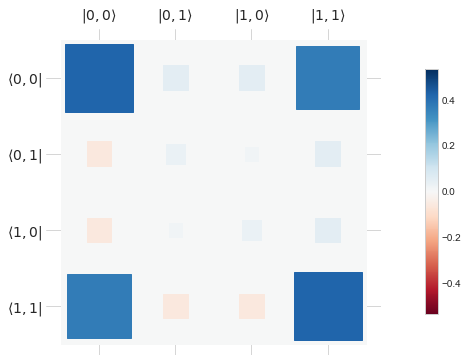

In [172]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [173]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 100#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [174]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([570.51280652+0.j, 868.22303992+0.j, 111.23907188+0.j,
       123.34225266+0.j, 490.43449904+0.j, 909.31457011+0.j,
       552.2498877 +0.j, 508.17936618+0.j, 730.23977565+0.j,
       152.51215613+0.j, 227.73955221+0.j, 391.91028554+0.j,
        87.76406558+0.j, 379.71004298+0.j, 802.47923107+0.j,
       434.98781492+0.j, 973.79087537+0.j, 249.97372084+0.j,
        53.4733104 +0.j, 816.28703018+0.j])

In [175]:
F(xi_opt, dt)

-3.0923592151047323

In [176]:
max_iter

100

In [177]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [178]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.46694228+0.j         -0.06836466-0.00025764j -0.06836466+0.00025764j
   0.53305772+0.j        ]
 [ 0.06833323-0.00013068j -0.02143934-0.00037561j -0.0444908 +0.00145757j
  -0.06833323+0.00013068j]
 [ 0.06833323+0.00013068j -0.0444908 -0.00145757j -0.02143934+0.00037561j
  -0.06833323-0.00013068j]
 [ 0.53305772+0.j          0.06836466+0.00025764j  0.06836466-0.00025764j
   0.46694228+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d143fd0>)

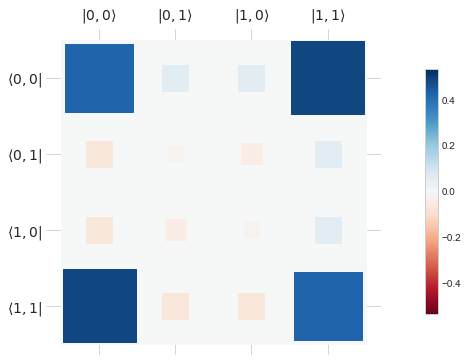

In [179]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [180]:
total_time = 3*pi/omega_1
epsilon = 10**(-6)
max_iter = 100#10**4#1000#100#50#20
time_steps = 200
dt = total_time/time_steps

In [181]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([237.65466843+0.j, 508.24962726+0.j, 289.91025734+0.j,
       263.03675497+0.j, 382.75909886+0.j, 758.18429588+0.j,
       365.26722222+0.j, 993.35429492+0.j, 925.60363856+0.j,
       308.1794209 +0.j, 436.35476602+0.j,  32.12798132+0.j,
       668.5762946 +0.j, 688.15843194+0.j, 665.56724616+0.j,
       676.73109552+0.j, 713.01469393+0.j, 327.27127681+0.j,
       198.96422291+0.j, 198.2605721 +0.j, 653.65498842+0.j,
       558.14166701+0.j,  58.59023271+0.j, 467.74301189+0.j,
       170.59372499+0.j, 905.93488418+0.j, 890.04063444+0.j,
        16.16094799+0.j, 234.06617656+0.j, 948.18600643+0.j,
       629.58057007+0.j, 714.52187161+0.j,  89.33018584+0.j,
       625.35399925+0.j, 394.52537054+0.j, 755.03151582+0.j,
       824.99546084+0.j, 718.10675758+0.j, 127.50000754+0.j,
        34.84936943+0.j, 149.12847563+0.j, 602.2268755 +0.j,
       812.60901946+0.j, 458.72292729+0.j, 331.45798281+0.j,
       715.45750023+0.j, 136.15487949+0.j, 835.95897567+0.j,
       307.4473213 +0.j,

In [182]:
F(xi_opt, dt)

-3.09202072847237

In [183]:
max_iter

100

In [184]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [185]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.47831394+0.j         -0.07182709+0.00733277j -0.07182709-0.00733277j
   0.52168606+0.j        ]
 [ 0.07250759+0.00234761j -0.01109665-0.00581203j -0.03308223-0.00863632j
  -0.07250759-0.00234761j]
 [ 0.07250759-0.00234761j -0.03308223+0.00863632j -0.01109665+0.00581203j
  -0.07250759+0.00234761j]
 [ 0.52168606+0.j          0.07182709-0.00733277j  0.07182709+0.00733277j
   0.47831394+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cc6ca58>)

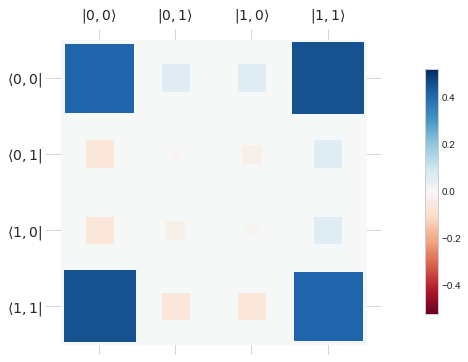

In [186]:
hinton(L_full_maker(xi_opt, dt))

### Try2

In [187]:
total_time = 3*pi/omega_1
epsilon = (0.1*2*pi)/(total_time)#10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

In [188]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([419.61730874+0.j, 436.11787593+0.j, 795.23025219+0.j,
       668.89545914+0.j, 206.0918092 +0.j, 224.24314024+0.j,
       544.06760369+0.j, 188.17593442+0.j, 412.89129216+0.j,
       998.35792598+0.j, 225.69626822+0.j, 408.61085666+0.j,
       265.36740427+0.j,  47.5006755 +0.j,  74.62748102+0.j,
        55.91104361+0.j, 490.12711559+0.j, 107.25434633+0.j,
       477.33861427+0.j, 539.7425936 +0.j])

In [190]:
F(xi_opt, dt)

-3.0922315020183513

In [191]:
max_iter

10

In [192]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [193]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.51194689+0.j          0.07495828-0.00010176j  0.07495828+0.00010176j
   0.48805311+0.j        ]
 [-0.07491794+0.00124167j  0.02358445-0.00099293j  0.00054376+0.00073191j
   0.07491794-0.00124167j]
 [-0.07491794-0.00124167j  0.00054376-0.00073191j  0.02358445+0.00099293j
   0.07491794+0.00124167j]
 [ 0.48805311+0.j         -0.07495828+0.00010176j -0.07495828-0.00010176j
   0.51194689+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d3c00b8>)

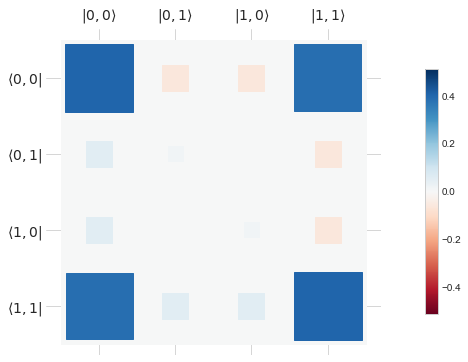

In [194]:
hinton(L_full_maker(xi_opt, dt))